# Factorization Machines

<span style="font-size:1.2em;">This notebook contains the process and progress of understanding factorization machines. The contents in this notebook can be found as follows:
1. Introduction and Concepts
2. Managing Dataset for FM Format
3. Constructing Model
4. Training Model
</span>

# 1. Introduction

<div style="font-size:1.2em;">Some of its features are:
    
* allows parameter estimation under sparse data
* works with **real valued feature vector** ?
* Use feature vectors as input data
    * Related to specialized SOTA factorization models

Scoring functions learned with pairwise training data? 
</div>

## Model

<span style="font-size:1.2em">
    
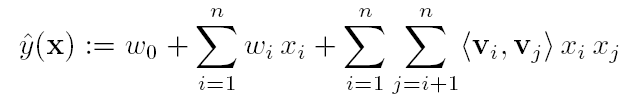

where,
* $ w_0 $ is the global bias
* $ w_i $ models strenght of $i-th $ variable

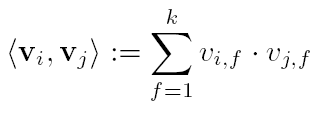

where,

* row $v_i$ within V describes i-th variable with ***k*** factors  

### FM models the interaction by factorizing it

- A FM can express any interaction matrix if k is chosen large enough,
    - but small k is favourable for sparse settings
 
## Losses in FM 

* Square loss
* Logit Loss
* Hinge Loss

Model parameters can be learnt with gradient descent methods(SGD)
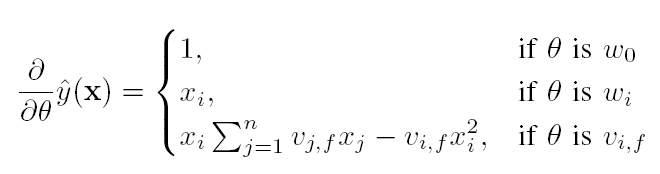
</span>

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
import torch.nn as nn
import torch

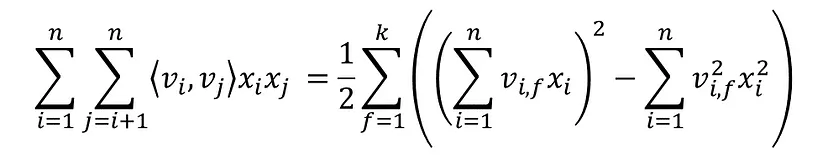

In [4]:
class FM(nn.Module):
    """ Factorization Machine
    """
    def __init__(self, num_feats, emb_dim, init):
        super().__init__()
        self.x_emb = nn.Embedding(num_feats, emb_dim)
        if init:
            self.x_emb.weight.data.uniform_(0., 0.05)

    def forward(self, X):
        x_emb = self.x_emb(X) # [bs, num_feats] -> [bs, num_feats, emb_dim]
        pow_of_sum = x_emb.sum(dim=1).pow(2) # -> [bs, num_feats]
        sum_of_pow = x_emb.pow(2).sum(dim=1) # -> [bs, num_feats]
        fm_out = (pow_of_sum - sum_of_pow).sum(1)*0.5  # -> [bs]
        result = self.sigmoid_func(fm_out, low=0.5)
        return fm_out
    
    def sigmoid_func(self, x, low=0, high=5.5):
        return torch.sigmoid(x) * (high-low) + low 

In [5]:
ratings_df = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', delimiter='\t', header=None, names=['userId', 'itemId', 'rating'], usecols=(0,1,2))

col_user = ['user_id','age','gender','occupation','zipcode']
users_df = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.user',sep='|', names=col_user)

# getting movies corresponding to itemId
movies_cols = ['movie_id', 'movie_title' , 'release_date' ,'video_release_date' ,'IMDb_URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,'Children' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,'Film-Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,'Thriller' , 'War' , 'Western']
movies_df = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item',sep='|', names=movies_cols, encoding='latin-1')

users_df.head(2), ratings_df.head(2), movies_df.head(2)

(   user_id  age gender  occupation zipcode
 0        1   24      M  technician   85711
 1        2   53      F       other   94043,
    userId  itemId  rating
 0     196     242       3
 1     186     302       3,
    movie_id       movie_title release_date  video_release_date  \
 0         1  Toy Story (1995)  01-Jan-1995                 NaN   
 1         2  GoldenEye (1995)  01-Jan-1995                 NaN   
 
                                             IMDb_URL  unknown  Action  \
 0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
 1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
 
    Adventure  Animation  Children  ...  Fantasy  Film-Noir  Horror  Musical  \
 0          0          1         1  ...        0          0       0        0   
 1          1          0         0  ...        0          0       0        0   
 
    Mystery  Romance  Sci-Fi  Thriller  War  Western  
 0        0        0       0         0    0        0  
 1    

## Difference between matrix factorization and factorization machine

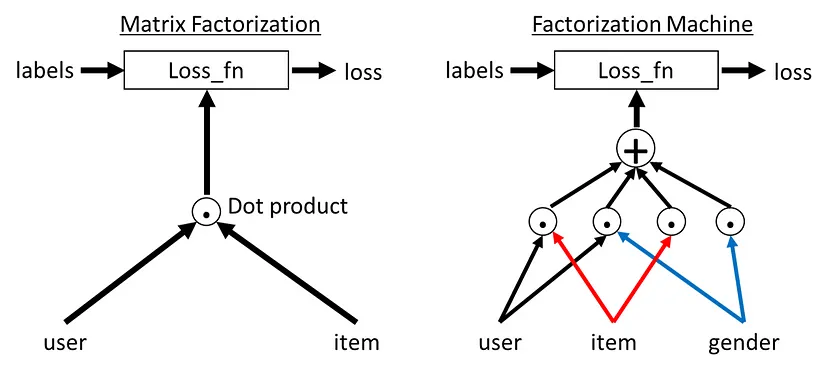

# 2. Managing Dataset for FM Format
<div style="font-size:1.2em;">

* Getting appropriate feature columns to add 

</div>

In [6]:
movies_df.columns, users_df.columns, ratings_df.columns

(Index(['movie_id', 'movie_title', 'release_date', 'video_release_date',
        'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children',
        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
        'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
        'Western'],
       dtype='object'),
 Index(['user_id', 'age', 'gender', 'occupation', 'zipcode'], dtype='object'),
 Index(['userId', 'itemId', 'rating'], dtype='object'))

In [7]:
movies_df[['movie_id', 'movie_title']]

,movie_id,movie_title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
...,...,...
1677,1678,Mat' i syn (1997)
1678,1679,B. Monkey (1998)
1679,1680,Sliding Doors (1998)
1680,1681,You So Crazy (1994)


In [82]:
ratings_df = ratings_df.rename(columns={'userId': 'user_id'})
ratings_df = ratings_df.rename(columns={'itemId': 'movie_id'})
# creating a merged df for getting titles, user_id and ratings 
merged_df2 = pd.merge(users_df, ratings_df, on="user_id")
print(merged_df2.head(2))

merged_df2 = pd.merge(merged_df2, movies_df[['movie_id', 'movie_title']], left_on='movie_id', right_on="movie_id")
merged_df2.head(2)

   user_id  age gender  occupation zipcode  movie_id  rating
0        1   24      M  technician   85711        61       4
1        1   24      M  technician   85711       189       3


,user_id,age,gender,occupation,zipcode,movie_id,rating,movie_title
0,1,24,M,technician,85711,61,4,Three Colors: White (1994)
1,1,24,M,technician,85711,189,3,"Grand Day Out, A (1992)"


In [83]:
# changing gender to numeric values
# 0 for male, 1 for female
merged_df2['gender_id'] = merged_df2['gender'].replace({'M':0, 'F':1})
merged_df2.gender_id.unique()

/tmp/ipykernel_34/2619475243.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df2['gender_id'] = merged_df2['gender'].replace({'M':0, 'F':1})


array([0, 1])

In [84]:
merged_df = merged_df2[['user_id', 'movie_id', 'rating', 'gender_id']]
merged_df

,user_id,movie_id,rating,gender_id
0,1,61,4,0
1,1,189,3,0
2,1,33,4,0
3,1,160,4,0
4,1,20,4,0
...,...,...,...,...
99995,943,415,1,0
99996,943,219,4,0
99997,943,796,3,0
99998,943,739,4,0


In [85]:
print(f'Unique users: {merged_df.user_id.nunique()}')
print(f'Unique movies: {merged_df.movie_id.nunique()}')
print(f'Unique genders: {merged_df.gender_id.nunique()}')
# print(f'Unique ages: {merged_df.age.nunique()}')

Unique users: 943
Unique movies: 1682
Unique genders: 2


In [86]:
feature_cols = ['user_id', 'movie_id', 'gender_id']
feature_sizes = {}
for feat in feature_cols:
    feature_sizes[feat] = len(merged_df[feat].unique())
    
feature_sizes.items() 

dict_items([('user_id', 943), ('movie_id', 1682), ('gender_id', 2)])

In [87]:
print(type(merged_df['movie_id'].head(1)[0])) 

<class 'numpy.int64'>


In [14]:
# starting which index the column value starts from 
feature_offsets = {} 
next_offset = 0
for k,v in feature_sizes.items():
    feature_offsets[k] = next_offset
    next_offset += v
print(feature_offsets)

for col in feature_cols:
    print(col)
    merged_df[col] = merged_df[col].apply(lambda x: x + int(feature_offsets[col]))
merged_df.head()

{'user_id': 0, 'movie_id': 943, 'gender_id': 2625}
user_id
movie_id
gender_id


,user_id,movie_id,rating,gender_id
0,1,1004,4,2625
1,1,1132,3,2625
2,1,976,4,2625
3,1,1103,4,2625
4,1,963,4,2625


In [15]:
# making feature columns and rating 
columns = ['rating', *feature_cols]

#defining maximum number of movies rated by users for test dataset
user_threshold = 3 
df_train = merged_df.groupby('user_id').head(-user_threshold)
df_test = merged_df.groupby('user_id').tail(user_threshold)
df_train.shape, df_test.shape, df_train.columns

((97171, 4),
 (2829, 4),
 Index(['user_id', 'movie_id', 'rating', 'gender_id'], dtype='object'))

# 3. Construction of Model

In [16]:
df_train.head(3)

,user_id,movie_id,rating,gender_id
0,1,1004,4,2625
1,1,1132,3,2625
2,1,976,4,2625


In [17]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [18]:
class Movies(Dataset):
    """
    df is the dataframe
    x is the feature cols
    y is the rating
    """
    def __init__(self, df, x, y):
        self.df = df 
        self.x = df[x].values
        self.y = df[y].values 
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index_):
        return self.x[index_], self.y[index_]

In [19]:
batch_size = 32
train_data = Movies(df_train, feature_cols, 'rating')
test_data = Movies(df_test, feature_cols, 'rating')
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True, num_workers=2)

x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([32, 3]), torch.Size([32]))

In [20]:
pd.concat([df_train, df_test]).max()

user_id       943
movie_id     2625
rating          5
gender_id    2626
dtype: int64

In [21]:
#num_feats, emb_dim, init
print(type(df_train), type(df_test))
num_feats = int(pd.concat([df_train, df_test]).max().max())
num_feats = num_feats + 1
print(num_feats)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
2627


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [23]:
model = FM(num_feats, emb_dim = 100, init = True)
model.to(device)

FM(
  (x_emb): Embedding(2627, 100)
)

In [24]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
loss_func = nn.MSELoss() 
print(f'Model weights are : {list(dict(model.named_parameters()).keys())}')

Model weights are : ['x_emb.weight']


# 4. Training the model 

In [25]:
epoch_train_losses = []
epoch_test_losses = [] 

for i in range(0):
    train_losses = []
    test_losses = []
    
    for x, y in train_dataloader:
        x,y = x.to(device), y.to(device, dtype=torch.float)
        predictions = model(x)
        
        loss = loss_func(predictions, y)
        train_losses.append(loss.cpu().detach().numpy())
        
        optimizer.zero_grad()
        
        loss.backward() 
        
        optimizer.step() 
        
    model.eval() 
    
    for x, y in test_dataloader:
        x,y = x.to(device), y.to(device, dtype=torch.float)
        
        predictions = model(x)
        
        loss = loss_func(predictions, y)
        
        test_losses.append(loss.cpu().detach().numpy())
        
    epoch_train_losses.append(np.mean(train_losses))
    epoch_test_losses.append(np.mean(test_losses))
    print(f'Epoch: {i}, Train Loss: {epoch_train_losses[-1]},Val Loss: {epoch_test_losses[-1]}')
    torch.save(model.state_dict(), f"model_epoch_{i}.pt")

Epoch: 0, Train Loss: 1.3970768451690674,Val Loss: 1.100016474723816
Epoch: 1, Train Loss: 0.9885761141777039,Val Loss: 1.080661416053772
Epoch: 2, Train Loss: 0.9735876321792603,Val Loss: 1.0623931884765625
Epoch: 3, Train Loss: 0.9552614092826843,Val Loss: 1.0583891868591309
Epoch: 4, Train Loss: 0.940586268901825,Val Loss: 1.0401452779769897
Epoch: 5, Train Loss: 0.9143773317337036,Val Loss: 1.0192943811416626
Epoch: 6, Train Loss: 0.8694080114364624,Val Loss: 0.9977539777755737
Epoch: 7, Train Loss: 0.8054777383804321,Val Loss: 0.9573162198066711
Epoch: 8, Train Loss: 0.7197973728179932,Val Loss: 0.9867874979972839
Epoch: 9, Train Loss: 0.6153737902641296,Val Loss: 0.9566689133644104
Epoch: 10, Train Loss: 0.50471431016922,Val Loss: 0.9395975470542908
Epoch: 11, Train Loss: 0.40545347332954407,Val Loss: 0.9613604545593262
Epoch: 12, Train Loss: 0.3202267289161682,Val Loss: 0.9749246835708618
Epoch: 13, Train Loss: 0.25302889943122864,Val Loss: 0.9914357662200928
Epoch: 14, Train Lo

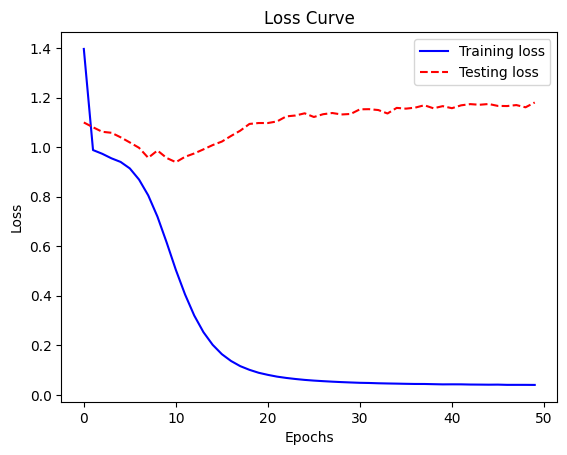

In [38]:
#plotting the loss curves
plt.plot(epoch_train_losses, c="b", label="Training loss")
plt.plot(epoch_test_losses, linestyle="--", c="r", label="Testing loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Curve")
plt.legend() 
plt.show()

In [66]:
# checking the results 
model.eval()
predictions_arr = []
ratings_arr = []

for x, y in test_dataloader:
    x,y = x.to(device), y.to(device, dtype=torch.float)
    predictions = model(x)
#     print(type(predictions))
    predictions_arr += predictions.cpu().detach().numpy().tolist()
    ratings_arr += y.cpu().detach().numpy().tolist()
    
min_ratings_pred = min(predictions_arr)
max_ratings_pred = max(predictions_arr)
print(min_ratings_pred, max_ratings_pred)

min_ratings_real =min(ratings_arr)
max_ratings_real = max(ratings_arr)
print(min_ratings_real, max_ratings_real)

-0.25103968381881714 6.471151828765869
1.0 5.0


In [68]:
import matplotlib

matplotlib.__version__

'3.7.5'

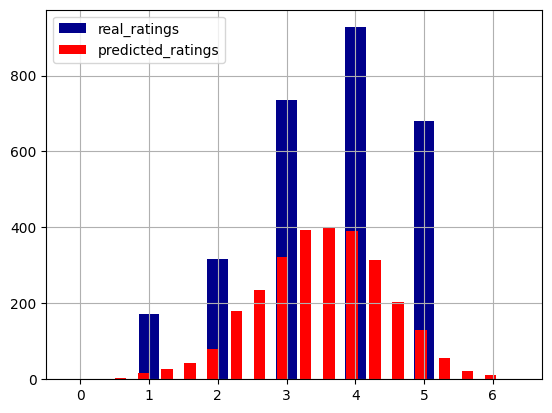

In [81]:
plt.hist(ratings_arr, label='real_ratings', bins=(np.arange(1,7)-0.5), color=['darkblue'], rwidth=0.3)
plt.hist(predictions_arr, label='predicted_ratings', bins=20, color='red', rwidth=0.5)
plt.grid()
plt.legend()
plt.show() 

# 5. Get Recommendations

In [88]:
merged_df2.columns

Index(['user_id', 'age', 'gender', 'occupation', 'zipcode', 'movie_id',
       'rating', 'movie_title', 'gender_id'],
      dtype='object')

In [96]:
merged_df2.head(2)

,user_id,age,gender,occupation,zipcode,movie_id,rating,movie_title,gender_id
0,1,24,M,technician,85711,61,4,Three Colors: White (1994),0
1,1,24,M,technician,85711,189,3,"Grand Day Out, A (1992)",0


In [156]:
# movie_title = 'Grand Day Out, A (1992)'
movie_title = 'Close Shave, A (1995)'
movie_index = merged_df2.loc[merged_df2['movie_title'] == movie_title, 'movie_id'].values[0]
movie_offset = movie_index + feature_offsets['movie_id']
movie_offset, movie_index 

(1351, 408)

In [157]:
num_movies = merged_df.movie_id.nunique()

all_movies_embeddings = model.x_emb(torch.arange(num_movies).to(device))
all_movies_embeddings.shape 

torch.Size([1682, 100])

torch.Size([100])
torch.Size([1682])


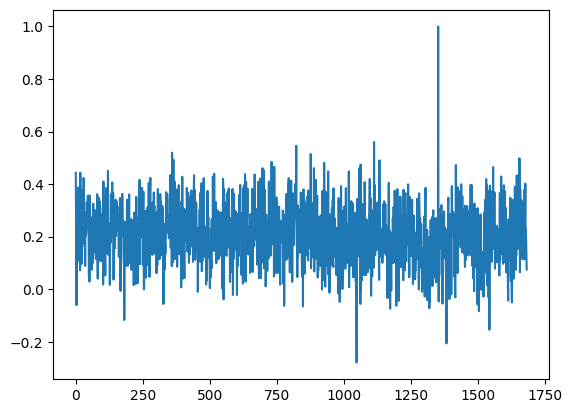

In [158]:
new_movie_embedding = model.x_emb(torch.tensor(movie_offset).to(device))
print(new_movie_embedding.shape) 

# cosine similarity
cosine_sim = torch.nn.functional.cosine_similarity(all_movie_embeddings, new_movie_embedding.unsqueeze(0))
print(cosine_sim.shape)
plt.plot(cosine_sim.cpu().detach().numpy())

In [159]:
# corresponding input for the model
movie_embedding = model.x_emb(torch.tensor(movie_offset).to(device))
movie_embedding.shape 

torch.Size([100])

In [165]:
# getting movies with top scores
top_n = 30 
similarities, top_indices = torch.topk(cosine_sim, k=top_n)
similarities, top_indices

(tensor([1.0000, 0.5602, 0.5461, 0.5194, 0.5145, 0.4981, 0.4927, 0.4904, 0.4848,
         0.4810, 0.4743, 0.4725, 0.4661, 0.4648, 0.4607, 0.4605, 0.4589, 0.4533,
         0.4504, 0.4485, 0.4484, 0.4435, 0.4433, 0.4391, 0.4380, 0.4367, 0.4349,
         0.4339, 0.4331, 0.4289], device='cuda:0', grad_fn=<TopkBackward0>),
 tensor([1351, 1112,  822,  359,  876, 1654,  364, 1132,  730,  926, 1062, 1417,
          740, 1556,  888,  696, 1057,  701,  120,  941, 1018,    0,   17,  516,
          631,  667,  353,  441, 1644, 1586], device='cuda:0'))

In [166]:
merged_df2.loc[merged_df2['movie_id']==1112-feature_offsets['movie_id'], 'movie_title'].values[0]

'Wrong Trousers, The (1993)'

In [167]:
feature_offsets['movie_id']

943

In [168]:
movie_index = movie_offset - feature_offsets['movie_id']
movies = []
for sim, idx in zip(similarities, top_indices):
    sim = sim.cpu().detach().numpy()
    try:
        movie_index = idx.cpu().detach().numpy()-feature_offsets['movie_id']
        movie_title = merged_df2.loc[merged_df2['movie_id']==movie_index, 'movie_title'].values[0]
        if movie_title in movies:
            continue
        else:
            movies.append((sim, movie_title))
        if len(movies)>10:
            break 
    except:
        pass

for m in movies:
    print(m)

(array(1., dtype=float32), 'Close Shave, A (1995)')
(array(0.56022227, dtype=float32), 'Wrong Trousers, The (1993)')
(array(0.4980924, dtype=float32), 'Substance of Fire, The (1996)')
(array(0.4903633, dtype=float32), 'Grand Day Out, A (1992)')
(array(0.47427964, dtype=float32), 'Maya Lin: A Strong Clear Vision (1994)')
(array(0.4725301, dtype=float32), 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)')
(array(0.4647751, dtype=float32), 'My Man Godfrey (1936)')
(array(0.45885924, dtype=float32), 'Wallace & Gromit: The Best of Aardman Animation (1996)')
(array(0.44840595, dtype=float32), 'Brother Minister: The Assassination of Malcolm X (1994)')
(array(0.4331398, dtype=float32), 'Wonderful, Horrible Life of Leni Riefenstahl, The (1993)')
(array(0.42887777, dtype=float32), 'The Innocent (1994)')
